In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from gym import Env, spaces
from qpython import qconnection
import numpy as np
import json
import pandas as pd 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
def _exec(qry, pandas=False):
        with qconnection.QConnection(
            host="localhost", 
            port=5050, 
            pandas=pandas) as q:
            return q.sendSync(qry) 

In [ ]:
data = _exec(".Q.ind[`events;30]", pandas=True)

In [4]:
q="""
derive:{[u]
    time:u[`resp][`data][`timestamp]; // should use this as ingress time
    a:flip u[`resp][`data][`asks][0];
    b:flip u[`resp][`data][`bids][0]; // should use utctime as egress time.
    :(20#"Z"$time;20#u[`utc_time];((10#`SELL),(10#`BUY));((reverse til 10),(til 10));`int$((a[0],b[0])*100);`int$(a[1],b[1]));
};
x:derive each (select from orderbook where utc_time within(min[utc_time];(min[utc_time]+(`minute$120))));
x:flip `time`intime`side`level`price`size!raze each flip x; 
(`time xasc x)
"""
orderbook = _exec(q,pandas=True)
# orderbook["cmd"]=(orderbook["cmd"]).apply(lambda x:x.decode("utf-8"))
# orderbook["kind"]=(orderbook["kind"]).apply(lambda x:x.decode("utf-8"))

In [ ]:
q="""
derive:{[u]
    time:u[`resp][`data][`timestamp]; // should use this as ingress time
    a:flip u[`resp][`data][`asks][0];
    b:flip u[`resp][`data][`bids][0]; // should use utctime as egress time.
    :(20#"Z"$time;20#u[`utc_time];((10#`SELL),(10#`BUY));`int$((a[0],b[0])*100);`int$(a[1],b[1]));
};
x:derive each .Q.ind[orderbookl;til 5000];
x:flip `time`intime`side`price`size!raze each flip x; 
x
"""
orderbookl = _exec(q,pandas=True)

In [13]:
q:"""
derive:{d:x[`resp][`data];:("Z"$d[`timestamp]; count[d]#x[`utc_time]; upper `$d[`side]; `int$(d[`price]*100); `int$d[`size])};
x: derive each .Q.ind[trade;til 5000];
x:flip raze each flip x;
x
"""
trades = _exec(q,pandas=True)
# trades["cmd"]=(trades["cmd"]).apply(lambda x:x.decode("utf-8"))
# trades["kind"]=(trades["kind"]).apply(lambda x:x.decode("utf-8"))# 
trades["side"]=(trades["side"]).apply(lambda x:x.decode("utf-8"))

994500

In [5]:
grd=pd.pivot_table(orderbook, values =["size",], index=['time'], columns = ["side","level"]).reset_index()

In [7]:
grd=[]

In [132]:
grd=grd["size"][:14000]

In [133]:
def fr(c): 
    try:
        return "_".join([c[0].decode("utf-8"),str(c[1])])
    except (UnicodeDecodeError, AttributeError):
        return str(c)

In [134]:
grd.columns = [fr(x) for x in grd.columns.tolist()]

In [135]:
mx=np.array(grd.transpose())

In [136]:
mxfrac=mx/np.sum(mx,axis=0)

In [137]:
mxfrac[10:].shape

(10, 14000)

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np

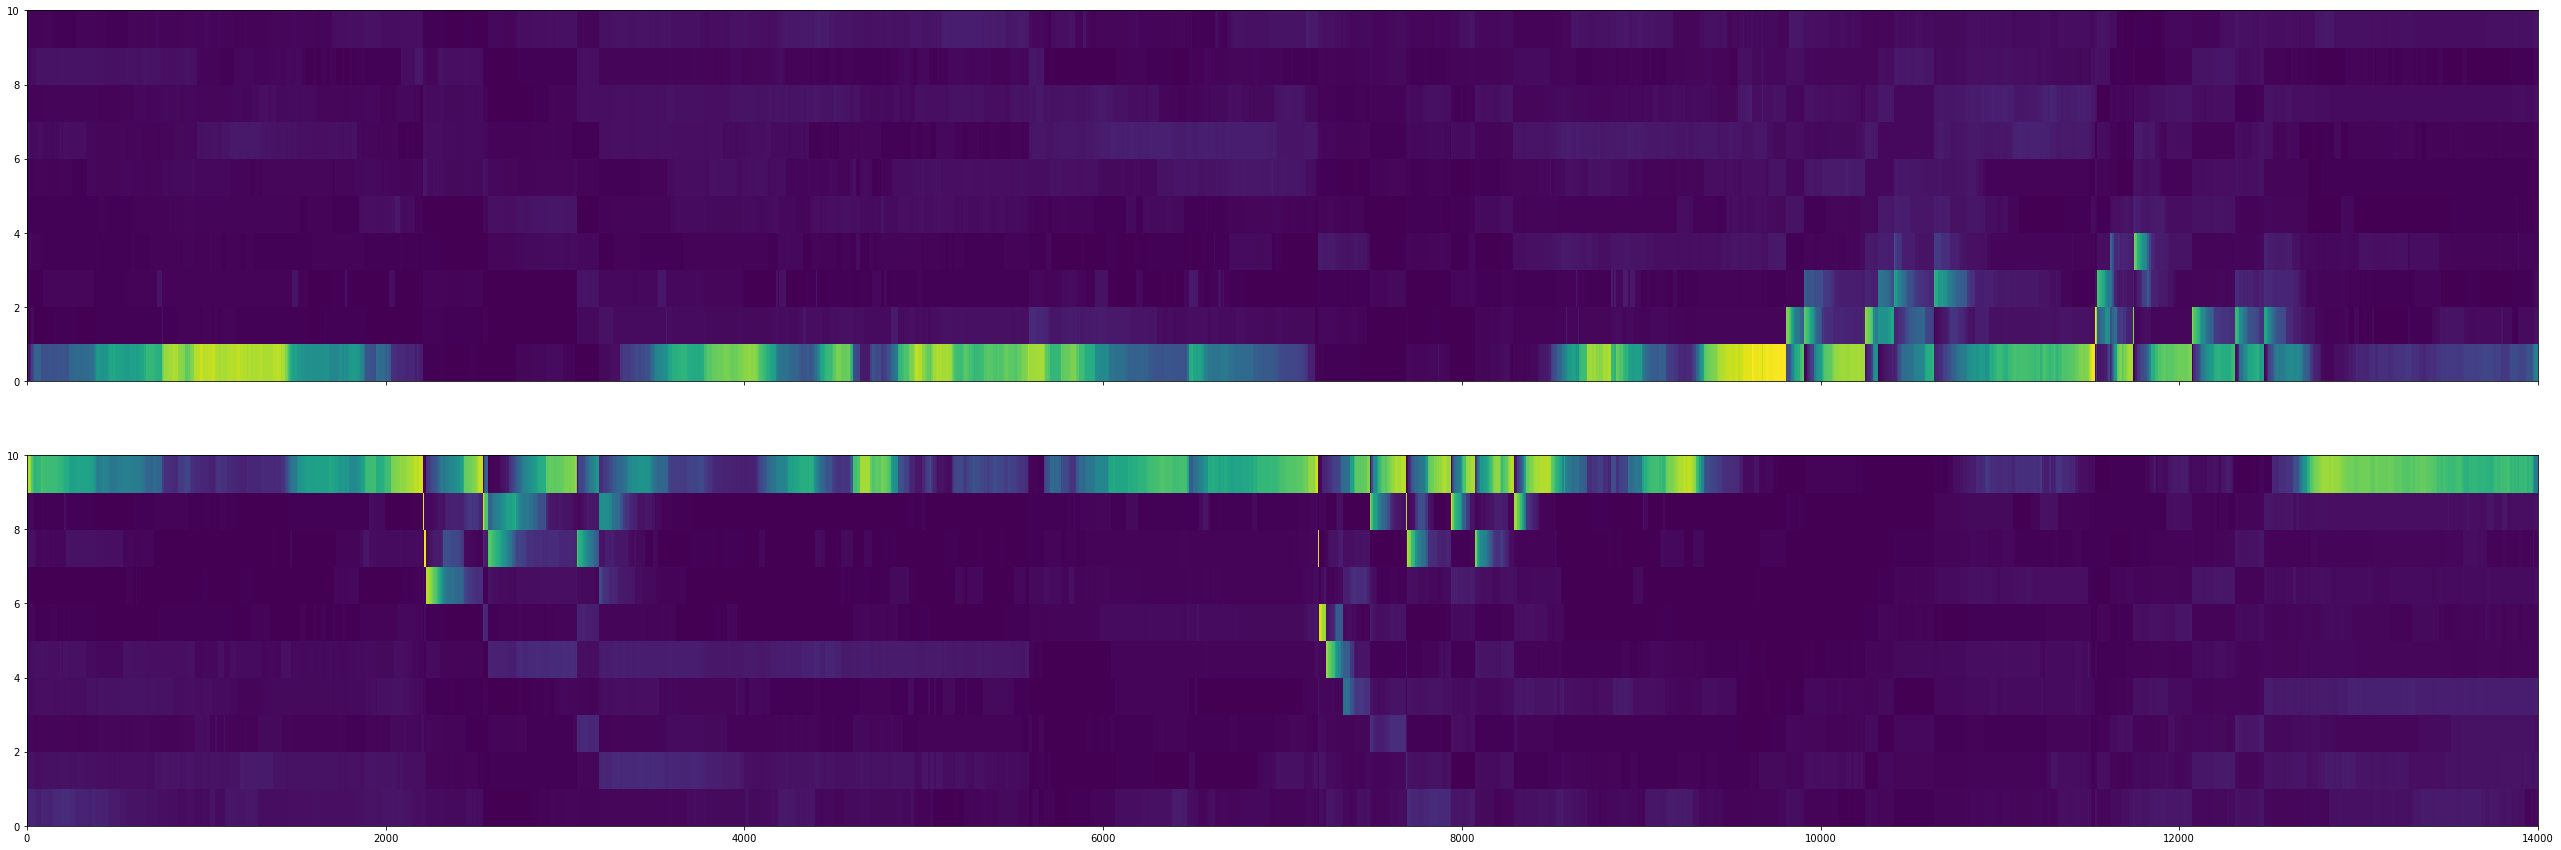

In [139]:
np.random.seed(19680801)
x = np.arange(14001)  # len = 11
y = np.arange(11)  # len = 7

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(45,15))
axs[0].pcolormesh(x, y, mxfrac[:10])
axs[1].pcolormesh(x, y, mxfrac[10:])

In [41]:
np.arange(4.5, 11, 1)

array([ 4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5])

In [42]:
np.arange(-0.5, 10, 1)

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5])

In [8]:
grd2=pd.pivot_table(orderbook, values =["size"], index=['time'], columns = ["price"]).reset_index()

In [11]:
grd2.fillna(method='ffill',inplace=True)
grd2.fillna(0,inplace=True)

In [12]:
grd2=grd2["size"][:440000]

In [10]:
grd2.shape

(447423, 445)

In [16]:
mx2=np.array(grd2.transpose())

In [17]:
mxfrac2=mx2/np.sum(mx2,axis=0)

In [18]:
mxfrac2.shape

(444, 440000)

In [ ]:
x = np.arange(440001)  # len = 11
y = np.arange(445)  # len = 7

fig, ax = plt.subplots(figsize=(45,15))
ax.pcolormesh(x, y, mxfrac2)